In [29]:
import pandas as pd
import matplotlib.pyplot as plt
from helper_functions import *
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from collections import defaultdict

In [30]:
save = True
load = False

### Import Data

In [31]:
dmr_esmr_mapping = pd.read_csv('processed_data/step1/dmr_esmr_mapping.csv')
parent_category_map = dict(zip(dmr_esmr_mapping['PARAMETER_CODE'], dmr_esmr_mapping['PARENT_CATEGORY']))
sub_category_map = dict(zip(dmr_esmr_mapping['PARAMETER_CODE'], dmr_esmr_mapping['SUB_CATEGORY']))

sub_categories = dmr_esmr_mapping['SUB_CATEGORY'].unique().tolist()
parent_categories = ['Nutrients']

In [32]:
facilities_list = pd.read_csv('data/facilities_list/NPDES+WDR Facilities List_20240906.csv')

limits_2023 = read_limits(2023)
limits_2023['PARENT_CATEGORY'] = limits_2023['PARAMETER_CODE'].map(parent_category_map)
limits_2023['SUB_CATEGORY'] = limits_2023['PARAMETER_CODE'].map(sub_category_map)
limits_2023.head()

# Import and process 303d lists for 2018 and 2024
columns_to_keep = ['Water Body CALWNUMS', 'Pollutant', 'Pollutant Category', 'Decision Status', 'TMDL Requirement Status',
                   'Sources', 'Expected TMDL Completion Date', 'Expected Attainment Date']

ir_parameter_df = pd.read_csv('processed_data/step1/ir_parameter_df.csv')
impaired_303d = {}
for year, rows_to_skip in [(2018, 2), (2024, 1)]:       
    impaired_303d[year] = pd.read_csv(f'data/ir/{year}-303d.csv', skiprows=rows_to_skip)[columns_to_keep].dropna(subset=['Water Body CALWNUMS'])
    # add a CATEGORY and SUB_CATEGORY column to impaired_303d_year, mapping from processed_data/step1/ir_parameter_df
    impaired_303d[year]['PARENT_CATEGORY'] = impaired_303d[year]['Pollutant'].map(dict(zip(ir_parameter_df['IR_PARAMETER_DESC'], ir_parameter_df['PARENT_CATEGORY'])))
    impaired_303d[year]['SUB_CATEGORY'] = impaired_303d[year]['Pollutant'].map(dict(zip(ir_parameter_df['IR_PARAMETER_DESC'], ir_parameter_df['SUB_CATEGORY'])))

# Load parameter sorting dictionary
with open('processed_data/step1/parameter_sorting_dict.json', 'r') as f:
    parameter_sorting_dict = json.load(f)

2023 has 74143 limits and 222 unique permits after filtering (155523 limits before filtering)


In [44]:
# Create a dictionary to store the newly impaired water bodies for each category
newly_impaired_water_bodies = defaultdict(set)
impaired_water_bodies = defaultdict(set)
for category in sub_categories:
    impaired_set_2018 = set(impaired_303d[2018].loc[impaired_303d[2018]['SUB_CATEGORY'] == category, 'Water Body CALWNUMS'])
    impaired_set_2024 = set(impaired_303d[2024].loc[impaired_303d[2024]['SUB_CATEGORY'] == category, 'Water Body CALWNUMS'])
    newly_impaired_water_bodies[category] = impaired_set_2024 - impaired_set_2018
    impaired_water_bodies[category] = impaired_set_2024

def contains_impaired_water_body(watershed_name, impaired_water_bodies):
    if pd.isna(watershed_name):
        return False
    return any(water_body in watershed_name for water_body in impaired_water_bodies)

new_columns = {}
for category in parent_categories + sub_categories:
    new_columns[f'Discharges to Newly {category} Impaired'] = False
    new_columns[f'Discharges to {category} Impaired'] = False
    new_columns[f'Discharges to Newly {category} Impaired and Not Limited'] = False

# Add new columns to facilities_list
facilities_list = facilities_list.assign(**new_columns)

# Check parent categories
for parent_category in parent_categories:
    print(f"Checking parent category: {parent_category}")
    facilities_list[f'Discharges to Newly {parent_category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=newly_impaired_water_bodies[parent_category])
    facilities_list[f'Discharges to {parent_category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=impaired_water_bodies[parent_category])
    print(parameter_sorting_dict[parent_category].keys())
    for index, row in facilities_list.iterrows():
        if row[f'Discharges to Newly {parent_category} Impaired']:
            sub_limits_2023 = limits_2023[limits_2023['EXTERNAL_PERMIT_NMBR'] == row['NPDES # CA#']]
            print(sub_limits_2023)
            for sub_category in parameter_sorting_dict[parent_category].keys():
                if not any((sub_limits_2023['SUB_CATEGORY'] == sub_category) & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'].notna()) & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'] != '') & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'] != 'nan')):
                    print(f"Facility {row['NPDES # CA#']} has no limit for {sub_category} discharging into {row['CAL WATERSHED NAME']}")
                    facilities_list.at[index, f'Discharges to Newly {parent_category} Impaired and Not Limited'] = True
                    break
                

# Check sub-categories
for sub_category in sub_categories:
    print(f"Checking sub-category: {sub_category}")
    facilities_list[f'Discharges to Newly {sub_category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=newly_impaired_water_bodies[sub_category])
    facilities_list[f'Discharges to {sub_category} Impaired'] = facilities_list['CAL WATERSHED NAME'].apply(contains_impaired_water_body, impaired_water_bodies=impaired_water_bodies[sub_category])
    
    for index, row in facilities_list.iterrows():
        if row[f'Discharges to Newly {sub_category} Impaired']:
            sub_limits_2023 = limits_2023[limits_2023['EXTERNAL_PERMIT_NMBR'] == row['NPDES # CA#']]
            if not any((sub_limits_2023['SUB_CATEGORY'] == sub_category) & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'].notna()) & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'] != '') & 
                       (sub_limits_2023['LIMIT_VALUE_NMBR'] != 'nan')):
                facilities_list.at[index, f'Discharges to Newly {sub_category} Impaired and Not Limited'] = True

Checking parent category: Nutrients
dict_keys(['Nitrogen', 'Phosphorus', 'Potassium', 'Algae and other Nutrient-related', 'Dissolved Oxygen'])
Checking sub-category: Radiation
Checking sub-category: Toxic Organics
Checking sub-category: Uranium
Checking sub-category: Other Organics
Checking sub-category: Toxic Inorganics
Checking sub-category: Other
Checking sub-category: Fuel
Checking sub-category: Tin
Checking sub-category: Disinfectants
Checking sub-category: Dissolved Solids
Checking sub-category: nan
Checking sub-category: Suspended Solids
Checking sub-category: Pathogens
Checking sub-category: Flow
Checking sub-category: Turbidity
Checking sub-category: COD
Checking sub-category: Nitrogen
Checking sub-category: Dissolved Oxygen
Checking sub-category: pH
Checking sub-category: Mercury
Checking sub-category: Thallium
Checking sub-category: Beryllium
Checking sub-category: Molybdenum
Checking sub-category: Nickel
Checking sub-category: Silver
Checking sub-category: Zinc
Checking sub

In [40]:
sub_limits_2023

,EXTERNAL_PERMIT_NMBR,LIMIT_SET_ID,PARAMETER_CODE,PARAMETER_DESC,MONITORING_LOCATION_CODE,LIMIT_VALUE_TYPE_CODE,LIMIT_VALUE_NMBR,LIMIT_VALUE_STANDARD_UNITS,LIMIT_UNIT_CODE,STANDARD_UNIT_CODE,...,STATISTICAL_BASE_TYPE_CODE,LIMIT_VALUE_QUALIFIER_CODE,LIMIT_FREQ_OF_ANALYSIS_CODE,LIMIT_TYPE_CODE,LIMIT_SET_DESIGNATOR,LIMIT_SET_SCHEDULE_ID,LIMIT_UNIT_DESC,LIMIT_SAMPLE_TYPE_CODE,PARENT_CATEGORY,SUB_CATEGORY


In [34]:
# consolidate to a single column. Add the category name(s) to the column
facilities_list['Discharges to Impaired Water Bodies and Not Limited'] = facilities_list.apply(
    lambda row: ', '.join(
        [category for category in sub_categories if row[f'Discharges to Newly {category} Impaired and Not Limited']
         ]
         ), axis=1)

# Add a column for the number of parameters
facilities_list['Discharges to Impaired and Not Limited: Number of Parameters'] = facilities_list.apply(
    lambda row: sum(
        [1 for category in sub_categories if row[f'Discharges to Newly {category} Impaired and Not Limited']
         ]
         ), axis=1)

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_46033/2732331987.py:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  facilities_list['Discharges to Impaired Water Bodies and Not Limited'] = facilities_list.apply(
/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_46033/2732331987.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  facilities_list['Discharges to Impaired and Not Limited: Number of Parameters'] = facilities_list.apply(


In [35]:
save = True
load = False
if save:
    facilities_list.to_csv('processed_data/step4/facilities_with_future_limits.csv', index=False)
if load:
    facilities_list = pd.read_csv('processed_data/step4/facilities_with_future_limits.csv')

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_46033/2834582838.py:28: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


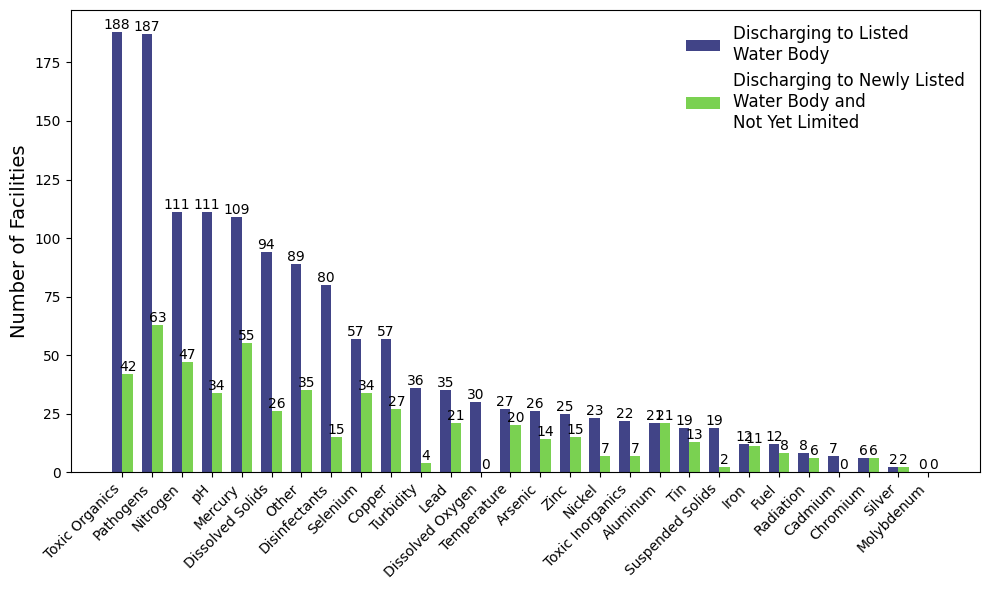

Total number of facilities: 974


In [36]:
# Create a more efficient visualization of the data
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np

all_categories = sub_categories + parent_categories
# Prepare the data
data = {}
for category in all_categories:
    if len(newly_impaired_water_bodies[category]) > 0:
        data[category] = {
            'Discharges to Listed': facilities_list[f'Discharges to {category} Impaired'].sum(),
            'Newly Listed and Not Yet Limited': facilities_list[f'Discharges to Newly {category} Impaired and Not Limited'].sum()
        }

# Convert to DataFrame for easier plotting
df = pd.DataFrame(data).T

# Sort the DataFrame by the sum of both columns, in descending order
df_sorted = df.sort_values(by=df.columns.tolist(), ascending=False)

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(df_sorted.index))
width = 0.35

# Use colors from viridis color map
viridis = plt.cm.get_cmap('viridis')
color1 = viridis(0.2)
color2 = viridis(0.8)

ax.bar(x - width/2, df_sorted['Discharges to Listed'], width, label='Discharging to Listed\nWater Body', color=color1)
ax.bar(x + width/2, df_sorted['Newly Listed and Not Yet Limited'], width, label='Discharging to Newly Listed\nWater Body and\nNot Yet Limited', color=color2)

plt.ylabel('Number of Facilities', fontsize=14)
plt.legend(fontsize=12, frameon=False)
plt.xticks(x, df_sorted.index, rotation=45, ha='right')

# Add value labels on the bars
for i, v in enumerate(df_sorted['Discharges to Listed']):
    ax.text(i - width/2, v, str(v), ha='center', va='bottom')
for i, v in enumerate(df_sorted['Newly Listed and Not Yet Limited']):
    ax.text(i + width/2, v, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.savefig('processed_data/step4/facilities_with_future_limits_efficient.png', dpi=300, bbox_inches='tight')
plt.show()

# Calculate and print percentages
total_facilities = len(facilities_list)
print(f"Total number of facilities: {total_facilities}")

for category in df_sorted.index:
    newly_listed = df_sorted.loc[category, 'Newly Listed and Not Yet Limited']
    percentage = (newly_listed / total_facilities) * 100

/var/folders/qq/0h1nl0vj595_tgrwtkm73yjm0000gn/T/ipykernel_46033/1889202820.py:20: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  viridis = plt.cm.get_cmap('viridis')


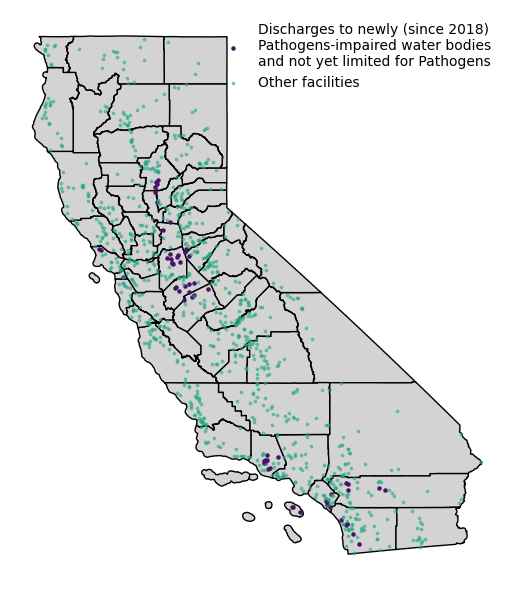

In [37]:
def plot_facilities_discharge(sub_category):
    # Create a GeoDataFrame from facilities_list
    gdf = gpd.GeoDataFrame(
        facilities_list, 
        geometry=[Point(xy) for xy in zip(facilities_list['LONGITUDE DECIMAL DEGREES'],
                                          facilities_list['LATITUDE DECIMAL DEGREES'])],
        crs="EPSG:4326"
    )

    california = gpd.read_file('data/ca_counties/CA_Counties.shp')

    # If CRS don't match, reproject one to match the other
    if gdf.crs != california.crs:
        if california.crs is None:
            california = california.set_crs(gdf.crs)
        else:
            gdf = gdf.to_crs(california.crs)

    # Get grey and blue colors from viridis palette
    viridis = plt.cm.get_cmap('viridis')
    grey_color = viridis(0.05)  # Grey color (closer to start of viridis)
    blue_color = viridis(0.6)  # Blue color (closer to middle of viridis)

    # plot county outlines and facilites
    fig, ax = plt.subplots(figsize=(6, 6))
    california.plot(ax=ax, color='lightgrey', edgecolor='black')
    gdf[gdf[f'Discharges to Newly {sub_category} Impaired and Not Limited'] == True].plot(ax=ax, color=grey_color, markersize=5, label=f'Discharges to newly (since 2018)\n{sub_category}-impaired water bodies\nand not yet limited for {sub_category}')
    gdf[gdf[f'Discharges to Newly {sub_category} Impaired and Not Limited'] == False].plot(ax=ax, color=blue_color, markersize=3, alpha=0.5, label='Other facilities')

    ax.legend(loc='upper right', frameon=False)
    ax.axis('off')

    plt.tight_layout()
    plt.show()

plot_facilities_discharge('Pathogens')

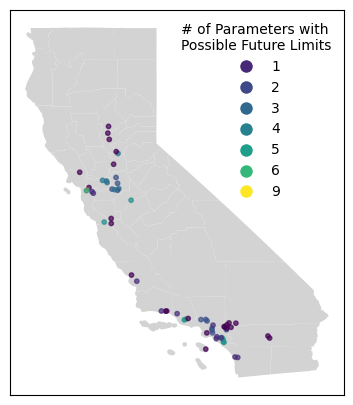

In [38]:
num_parameters_per_facility = dict(zip(facilities_list['NPDES # CA#'], facilities_list['Discharges to Impaired and Not Limited: Number of Parameters']))
num_parameters_per_facility = {k: v for k, v in num_parameters_per_facility.items() if v >= 1}
plot_facilities_map(num_parameters_per_facility, '# of Parameters with\nPossible Future Limits', 10)